
# Problem set 2

## Problem 1
Consider a pendulum of length $l=1$ in a gravitational field with $g=1$. Let $\theta$ be the angle with respect to the vertical direction.

- Assuming an initial condition $\theta(t=0)=\theta_0$ and $\dot{\theta}(t=0)=0$, solve the equation of motion without approximations in the interval $t\in[0,4\pi]$ for different values of the initial condition in the range $\theta_0\in[0,\pi]$.

- For each of those values, compare the solution with the solution you'd find in the usual approximation $\theta\ll1$. Plot also the trajectory of the pendulum in phase space (i.e. in the plane $(\theta,\dot{\theta})$).

**Hints**:
- The equation of motion in this case is:
\begin{equation}
\ddot{\theta}+\sin\theta=0
\end{equation}
- Look up the function `scipy.integrate.solve_ivp`. Note that you'll have to rephrase the second-order equation above as a set of 2 linear first-order equations of the form $\dot{\bf x}={\bf f}({\bf x},t)$.

### Solution
OK, we start by rewriting the equations as a system of first-order equations:
\begin{align}
\dot{\theta}=q,\hspace{12pt}\dot{q}=-\sin\theta
\end{align}

Then, we set up the function that we will pass to `solve_ivp`.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

def f_pendulum(t, y):
    theta = y[0]
    q = y[1]
    return np.array([q, -np.sin(theta)])

Let's integrate it for the different initial conditions. Since `solve_ivp` also gives us the velocities $\dot{\theta}$, we'll store them as well:

In [2]:
n_ini = 10
# Initial conditions
theta_ini = np.linspace(0, np.pi, n_ini)
# time values to evaluate the solutions
t_vals = np.linspace(0, 4*np.pi, 512)

theta_sol = []
q_sol = []
# Iterate through initial conditions
for th0 in theta_ini:
    # Solve for this particular initial condition
    sol = solve_ivp(f_pendulum, (0, 4*np.pi), [th0, 0], t_eval=t_vals)
    # Store theta and velocities
    theta_sol.append(sol.y[0])
    q_sol.append(sol.y[1])
theta_sol = np.array(theta_sol)
q_sol = np.array(q_sol)

In addition, let's calculate the approximate solution to the equation:
\begin{equation}
  \theta(t)=\theta_0\cos(t)
\end{equation}

In [3]:
theta_approx = np.array([th0 * np.cos(t_vals) for th0 in theta_ini])

Alright, let's plot things!
First, the comparison with the linear approximation:

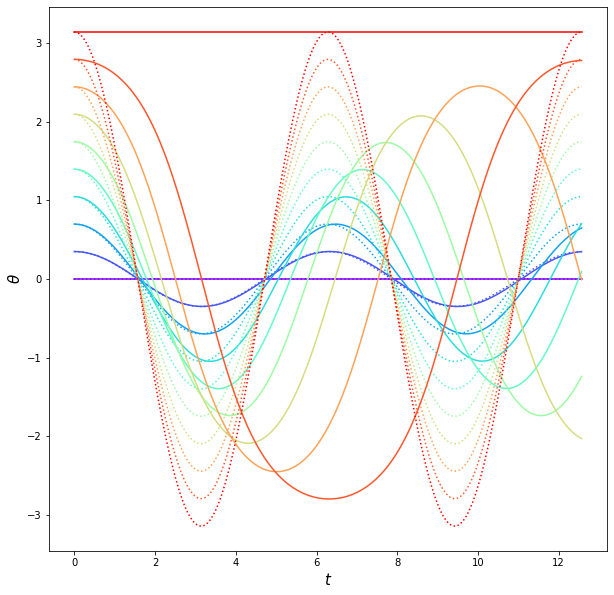

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Colors to loop through
cols = cm.rainbow(np.linspace(0,1,n_ini))

# Loop through initial conditions
plt.figure(figsize=(10,10))
for th, th_a, c in zip(theta_sol, theta_approx, cols):
    plt.plot(t_vals, th, '-', c=c)
    plt.plot(t_vals, th_a, ':', c=c)
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$\theta$', fontsize=15)
plt.show()

Now we plot the phase-space trajectories:

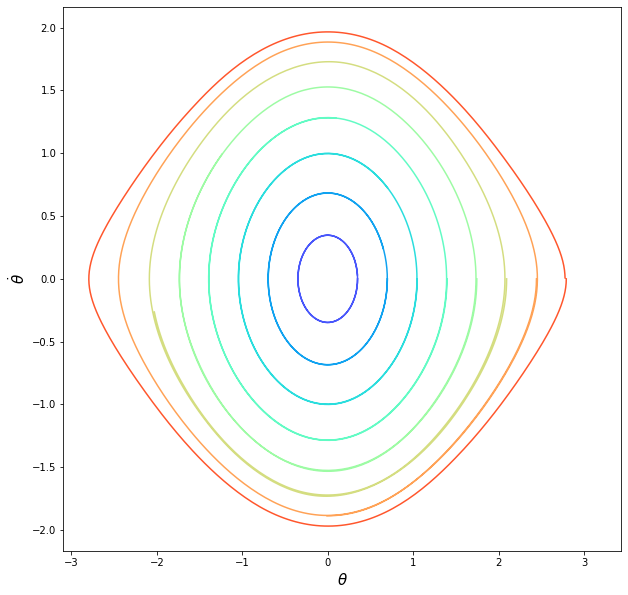

In [6]:
plt.figure(figsize=(10,10))
for th, q, c in zip(theta_sol, q_sol, cols):
    plt.plot(th, q, c=c)
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\dot{\theta}$', fontsize=15)
plt.show()

Notice that the trajectories don't completely close on themselves! Should we worry about this?

This is probably due to numerical inaccuracies. We can check for those, for example, by verifying to what extent energy is conserved in the system. In our case energy is simply given by
\begin{equation}
E\propto \frac{\dot{\theta}^2}{2}+(1-\cos\theta)=\frac{q^2}{2}-\cos\theta+{\rm const.}
\end{equation}

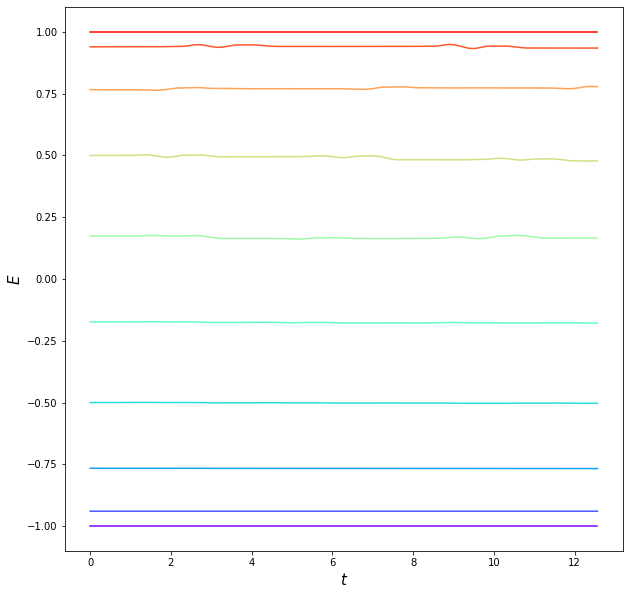

In [7]:
energy = 0.5*q_sol**2-np.cos(theta_sol)

plt.figure(figsize=(10, 10))
for en, c in zip(energy, cols):
    plt.plot(t_vals, en, c=c)
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$E$', fontsize=15)
plt.show()

## Problem 2
In tutorials, we've seen an equation one can use to find the trajectory $r(\varphi)$ of a given object under a central force:
\begin{equation}
  F(1/u) + \frac{J^2u^3}{m} = - \frac{J^2u^2}{m}\frac{d^2u}{d\varphi^2},
\end{equation}
where $u=1/r$, $F(r)$ is the modulus of the central force, $J$ is the constant angular momentum of the moving object, and $\varphi$ is the azimuth angle.

1. Solve this equation numerically to find the trajectory of Mercury, using its perihelium as an initial condition. Plot the trajectory in the $(x,y)$ plane in the interval $\varphi\in[0,20\pi]$. You'll need the following numbers:
 - Perihelion distance: $4.6\times10^7\,\,{\rm km}$.
 - Aphelion distance: $7.0\times10^7\,\,{\rm km}$.
 - Mercury's mass: $3.3\times10^{23}\,\,{\rm kg}$.
 - Sun's mass: $2\times10^{30}\,{\rm kg}$.
 - Gravitational constant: $G=6.67\times10^{-11}\,{\rm m^3\,s^{-2}\,kg^{-1}}$

2. Calculate the total area swept by Mercury's trajectory as a function of $\varphi$. Does it match the number you would expect?

3. Einstein's theory of relativity introduces one extra term on $F(r)$, so that the effective force is (note: put in the missing factors of $c$!):
\begin{equation}
F(r)=-\frac{GMm}{r^2}\left(1+\frac{3J^2}{m^2r^2}\right)
\end{equation}
Plot Mercury's trajectory again with this addictional force.

4. Relativistic effects are very small, mostly because $c$ is very large. To see them clearly, let's make $c$ 1000 times smaller, and plot the previous trajectory again.



**Hints**
- Note that all the numbers above are pretty large. Change the units of the variable $u$ so it takes values of order $\mathcal{O}(1)$.
- To solve part 2, look at other functions within the `scipy.integrate` module that may help you do this.

### Solution
OK, first of all we're gonna need to compute the angular momentum. If we use conservation of mass and conservation of energy, we get that (derive this yourself!):
\begin{equation}
J=m\sqrt{\frac{2GM_\odot r_p r_a}{r_p+r_a}}.
\end{equation}

Now let's think about units. The natural units of length for this problem would be e.g. the orbit's perihelium $r_p$, so we'll make $r_p=1$ in these units. For mass, we could use Mercury's mass. Moreover, because of the Equivalence Principle (look this up!), this orbit should not depend on Mercury's mass at all! If we look at the equation above, we see that this is indeed the case, and we can write it as:
\begin{equation}
  -GM_\odot u^2 + j^2u^3 = - j^2u^2\frac{d^2u}{d\varphi^2},
\end{equation}
where I have defined the angular momentum per unit mass $j\equiv J/m$. Now, if we define the unitless quantity $w=r_p/r=r_p u$, the equation above reads:
\begin{equation}
  \frac{d^2w}{d\varphi^2} = \frac{GM_\odot r_p}{j^2} - w,
\end{equation}
which we can now write as a system of two linear equations
\begin{align}
  &\frac{dw}{d\varphi} = z,\\
  &\frac{dz}{d\varphi} = \frac{GM_\odot r_p}{j^2} - w,
\end{align}


Alright, let's start defining all the quantities we need:


In [8]:
# Change to meters!
r_p = 4.6E10
r_a = 7E10
GMsun = 6.67E-11 * 2E30
j = np.sqrt(2*GMsun * r_p * r_a / (r_p + r_a))

Now, as before, let's define the function we'll pass to `solve_ivp`

In [9]:
def f_Newton(t, y):
    w = y[0]
    z = y[1]
    return np.array([z, GMsun*r_p / j**2 - w])

Now solve! (What should the initial conditions be?)

In [10]:
phi_vals = np.linspace(0, 20*np.pi, 1024)
sol = solve_ivp(f_Newton, (0, 20*np.pi), [1, 0], t_eval=phi_vals)

OK, now we put this in 2D. We need to undo the coordinate transformations above. Let's do it:
\begin{align}
 x = \frac{r_p}{w}\cos\varphi,\hspace{12pt} y = \frac{r_p}{w}\sin\varphi
\end{align}

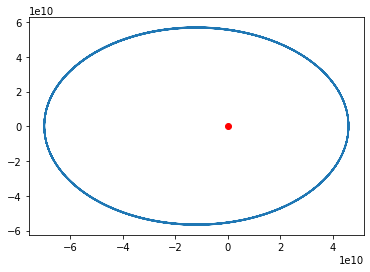

In [11]:
x = r_p / sol.y[0] * np.cos(phi_vals)
y = r_p / sol.y[0] * np.sin(phi_vals)

plt.figure()
plt.plot(x, y)
plt.plot([0],[0], 'ro')
plt.show()

Eureka!

Including the relativistic correction modifies our equations as follows:
\begin{align}
  &\frac{dw}{d\varphi} = z,\\
  &\frac{dz}{d\varphi} = \frac{GM_\odot r_p}{j^2}\left(1+\frac{3j^2}{c^2r_p^2}w^2\right) - w,
\end{align}
So let's modify the integrand accordingly:

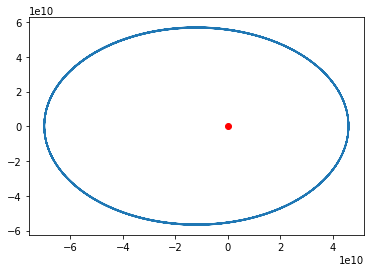

In [13]:
# Speed of light in m/s
c_light = 3E8

def f_Einstein(t, y):
    w = y[0]
    z = y[1]
    return np.array([z, GMsun*r_p / j**2 * (1+3*(j*w/r_p/c_light)**2) - w])

# Now solve and plot!
def solve_and_plot():
    sol = solve_ivp(f_Einstein, (0, 20*np.pi), [1, 0], t_eval=phi_vals)
    x = r_p / sol.y[0] * np.cos(phi_vals)
    y = r_p / sol.y[0] * np.sin(phi_vals)
    plt.figure()
    plt.plot(x, y)
    plt.plot([0],[0], 'ro', lw=0.1)
    plt.show()
solve_and_plot()

Hummm, not much difference... This is probably because relativistic effects are tiny! How can we make them larger?
Let's make the speed of light much smaller!

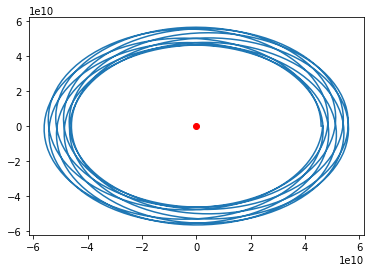

In [14]:
c_light = 3E5
solve_and_plot()

Alright, that's something! Look up http://hosting.astro.cornell.edu/academics/courses/astro201/merc_adv.htm

## Problem 3
Consider a system of two pendula, where the second pendulum, of the same mass and length, is simply attached to the end of the first pendulum considered in Problem 1. Label the angles of both pendula with respect to the vertical $\theta_1$ and $\theta_2$.

The equations of motion for this system are:
\begin{align}
&\ddot{\theta}_1=\frac{-2\sin\theta_1+\sin\theta_2\cos(\theta_1+\theta_2)+\dot{\theta}_2^2\sin(\theta_1+\theta_2)-\dot{\theta}_1^2\sin(\theta_1+\theta_2)\cos(\theta_1+\theta_2)}{1+\sin^2(\theta_1+\theta_2)},\\
&\ddot{\theta}_2=\frac{-2\sin\theta_2+2\sin\theta_1\cos(\theta_1+\theta_2)+2\dot{\theta}_1^2\sin(\theta_1+\theta_2)-\dot{\theta}_2^2\sin(\theta_1+\theta_2)\cos(\theta_1+\theta_2)}{1+\sin^2(\theta_1+\theta_2)}.
\end{align}

- Assuming an initial condition $\theta_1(t=0)=0$, $\theta_2(t=0)=\theta_0$ and $\dot{\theta}_i(t=0)=0$, solve the equation of motion without approximations in the interval $t\in[0,10\pi]$ for $\theta_0=\pi/10$, $\theta_0=\pi/4$, $\theta_0=\pi/2$ and $\theta_0=9\pi/10$.

- Use the solution from the previous part to plot the total energy of the system as a function of time for the same initial conditions.

### Solution
OK, let's start by setting up the function to integrate.

In [15]:
def f_pendula(t, y):
    t1, t2, q1, q2 = y
    s1 = np.sin(t1)
    s2 = np.sin(t2)
    s12 = np.sin(t1+t2)
    c12 = np.cos(t1+t2)
    f1 = (-2*s1+s2*c12+q2**2*s12-q1**2*s12*c12)/(1+s12**2)
    f2 = (-2*s2+2*s1*c12+2*q1**2*s12-q2**2*s12*c12)/(1+s12**2)
    return np.array([q1, q2, f1, f2])
    

Now, before we go around solving solutions, It's always a good idea to have something to compare with to make sure whatever we code up doesn't have any bugs. In this case, it's a good idea to first derive the the linear approximation to these equations and its corresponding solution (which should be valid when $\theta_0$ is small).

The linearized equation is:
\begin{align}
 &\ddot{\theta}_1=-2\theta_1+\theta_2,\\
 &\ddot{\theta}_2=2\theta_1-2\theta_2,
\end{align}
and its solution for the initial conditions above is:
\begin{align}
&\theta_1 = \frac{\theta_0}{\sqrt{2}}\sin\left(\sqrt{1+2^{-1/2}}t\right)\sin\left(\sqrt{1-2^{-1/2}}t\right),\\
&\theta_2 = \theta_0\cos\left(\sqrt{1+2^{-1/2}}t\right)\cos\left(\sqrt{1-2^{-1/2}}t\right),
\end{align}

So let's code that up too.

In [16]:
def sol_linear(t, th0):
    omega_plus = np.sqrt(1+1/np.sqrt(2))
    omega_minus = np.sqrt(1-1/np.sqrt(2))
    return np.array([th0*np.sin(omega_plus*t)*np.sin(omega_minus*t)/np.sqrt(2),
                     th0*np.cos(omega_plus*t)*np.cos(omega_minus*t)])

Ok, now let's compare both of them for a small initial condition (e.g. $\theta_0=\pi/100$):

In [17]:
theta_0 = np.pi/100
# Output times
t_vals = np.linspace(0, 10*np.pi, 1024)

# Exact solution
sol = solve_ivp(f_pendula, (0, 10*np.pi), [0, theta_0, 0, 0], t_eval=t_vals)

# Approximate solution
sol_lin = sol_linear(t_vals, theta_0)

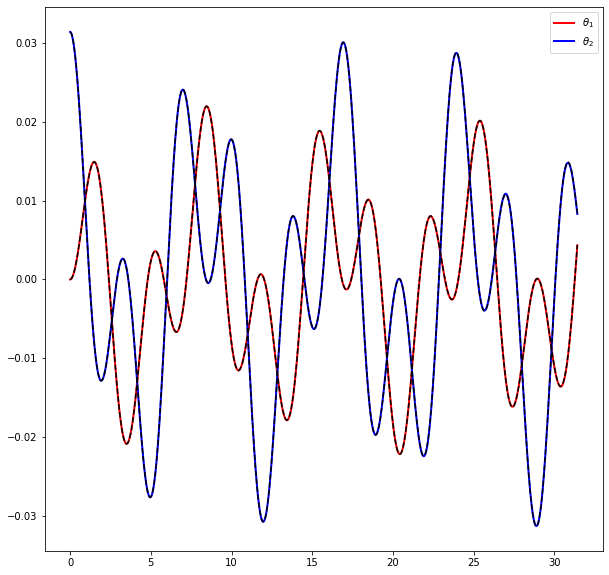

In [18]:
# Plotting time!
plt.figure(figsize=(10, 10))
plt.plot(t_vals, sol.y[0], 'r-', lw=2, label=r'$\theta_1$')
plt.plot(t_vals, sol.y[1], 'b-', lw=2, label=r'$\theta_2$')
plt.plot(t_vals, sol_lin[0], 'k--')
plt.plot(t_vals, sol_lin[1], 'k--')
plt.legend()
plt.show()


OK, amazing!

Now, to explore the different initial conditions, let's just write a function that computes the solutions and generates a plot.

In [19]:
def solve_and_plot(theta_0, title):
    # Exact solution
    sol = solve_ivp(f_pendula, (0, 10*np.pi), [0, theta_0, 0, 0], t_eval=t_vals)
    # Approximate solution
    sol_lin = sol_linear(t_vals, theta_0)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.plot(t_vals, sol.y[0], 'r-', lw=2, label=r'$\theta_1$')
    plt.plot(t_vals, sol.y[1], 'b-', lw=2, label=r'$\theta_2$')
    plt.plot(t_vals, sol_lin[0], 'k--')
    plt.plot(t_vals, sol_lin[1], 'k--')
    plt.legend()
    plt.show()


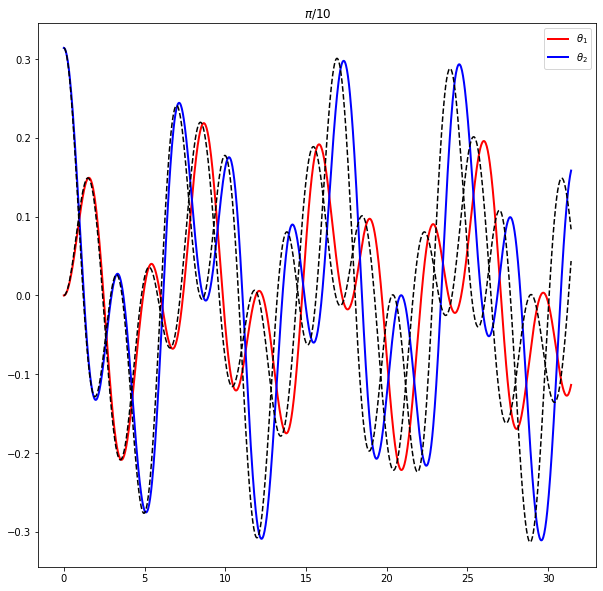

In [20]:
solve_and_plot(np.pi/10, r'$\pi/10$')

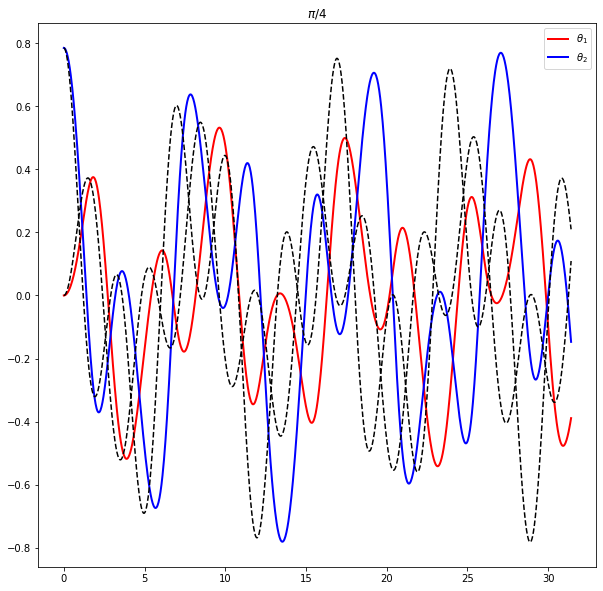

In [21]:
solve_and_plot(np.pi/4, r'$\pi/4$')

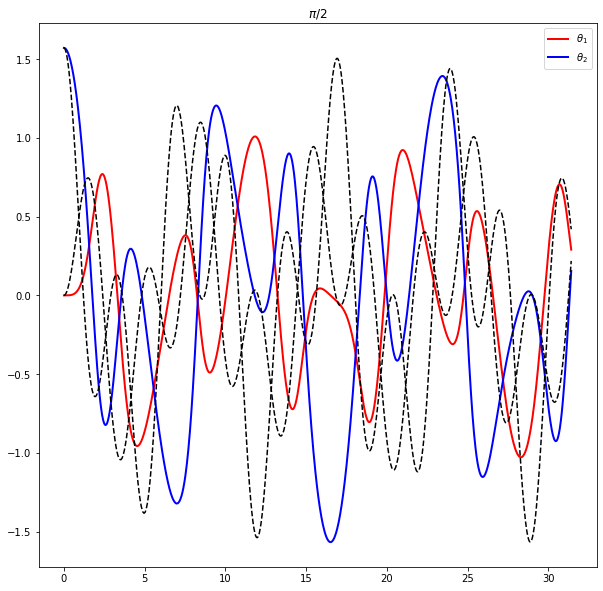

In [22]:
solve_and_plot(np.pi/2, r'$\pi/2$')

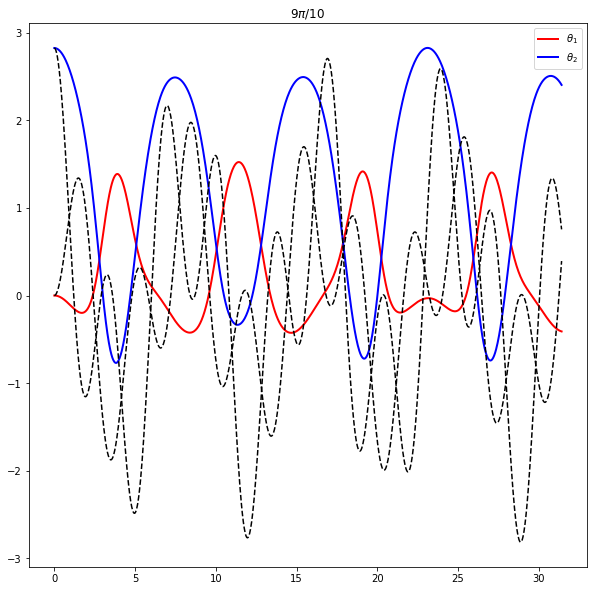

In [23]:
solve_and_plot(9*np.pi/10, r'$9\pi/10$')

OK, now let's look at the energy. For this system, you should be able to derive that the energy is given by:
\begin{equation}
  E \propto \frac{1}{2}\left(2\dot{\theta}_1^2+\dot{\theta}_2^2+2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1+\theta_2)\right)-2\cos\theta_1-\cos\theta_2
\end{equation}

Now let's modify our previous function to return the energy instead of the $\theta$s:

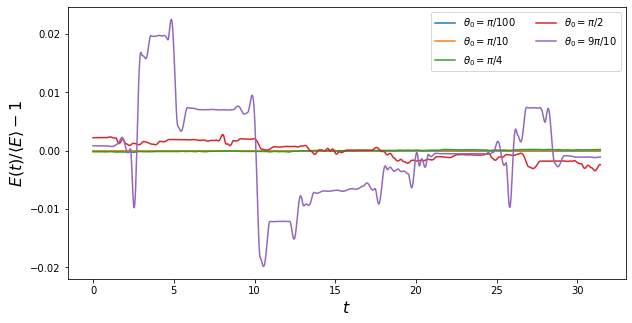

In [24]:
def get_energy(theta_0, label):
    sol = solve_ivp(f_pendula, (0, 10*np.pi), [0, theta_0, 0, 0], t_eval=t_vals)
    t1, t2, q1, q2 = sol.y
    c1 = np.cos(t1)
    c2 = np.cos(t2)
    c12 = np.cos(t1+t2)
    energy = 0.5 *(2*q1**2+q2**2+2*q1*q2*c12)-2*c1-c2
    plt.plot(t_vals, energy/np.mean(energy)-1, label=label)

plt.figure(figsize=(10, 5))
get_energy(np.pi/100, r'$\theta_0=\pi/100$')
get_energy(np.pi/10, r'$\theta_0=\pi/10$')
get_energy(np.pi/4, r'$\theta_0=\pi/4$')
get_energy(np.pi/2, r'$\theta_0=\pi/2$')
get_energy(9*np.pi/10, r'$\theta_0=9\pi/10$')
plt.legend(loc = 'upper right', ncol=2)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E(t)/\langle E\rangle - 1$', fontsize=16)
plt.show()

So, in the most extreme case, energy conservation is getting dubious...